In [15]:
import numpy as np
import matplotlib.pyplot as plt
import adaptive_latents
import itertools
from adaptive_latents import CenteringTransformer, Pipeline, proSVD, KernelSmoother, sjPCA, mmICA, AnimationManager
from adaptive_latents import datasets
from sklearn.decomposition import PCA
from tqdm.notebook import tqdm
import pandas as pd
Leventhal24uDataset = datasets.Leventhal24uDataset

In [16]:
d = Leventhal24uDataset(bin_size=.2)


Reading Intan Technologies RHD Data File, Version 1.5

Found 64 amplifier channels.
Found 3 auxiliary input channels.
Found 1 supply voltage channel.
Found 8 board ADC channels.
Found 16 board digital input channels.
Found 16 board digital output channels.
Found 0 temperature sensors channels.

Header file contains no data.  Amplifiers were sampled at 20.00 kS/s.
Done!  Elapsed time: 0.0 seconds


In [17]:
d.trial_data[d.trial_data['correct']==True].tone

2       211.12585
5       274.62790
6       288.62475
7       300.11055
9       321.03705
          ...    
119    3264.95535
121    3356.51145
123    3414.59035
124    3433.77315
126    3582.67150
Name: tone, Length: 67, dtype: float64

* pretone is tone - centerIn
* RT is centerOUt - tone
* MT is sideIn - centerOut 

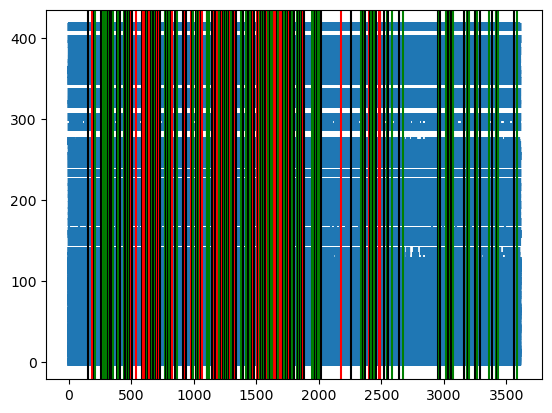

In [18]:
%matplotlib inline
plt.scatter(d.spike_times, d.spike_clusters, marker='|')
for i, row in d.trial_data.iterrows():
    if row['valid']:
        plt.axvline(row['cueOn'], color='k')
        if row['correct']:
            plt.axvline(row['tone'], color='green')
        else:
            plt.axvline(row['tone'], color='red')

        # plt.axvline(row['centerOut'], color='C1')
    # plt.axvline(row['Time'] + row['SideInToFood'], color='C2')
    # plt.axvline(row['Time'] + row['MT'], color='C3')
    # plt.axvline(row['Time'] + row['pretone'], color='C1')
    

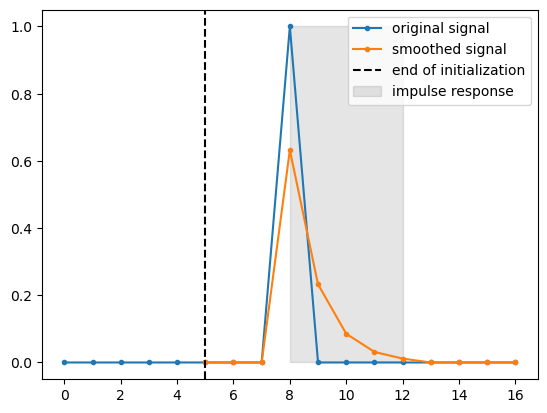

In [19]:
fig, ax = plt.subplots()
KernelSmoother(tau=1, kernel_length=5*1).plot_impulse_response(ax)

1476710.0
1466038.9805375326


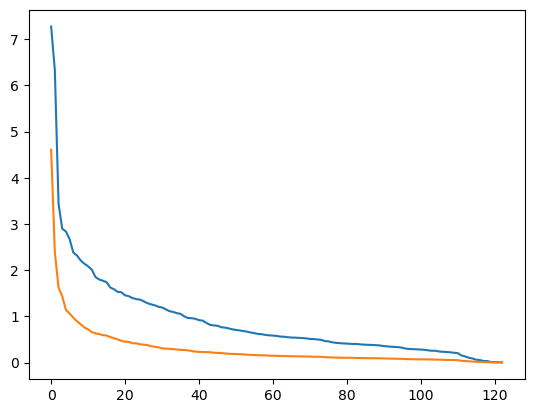

In [20]:
%matplotlib inline
a = np.squeeze(d.neural_data.a)
plt.plot(PCA().fit(a).explained_variance_)
print(a.sum())
a = KernelSmoother(kernel_length=10, tau=2).offline_run_on(a)
plt.plot(PCA().fit(a).explained_variance_)
print(a.sum())



(200.0, 400.0)

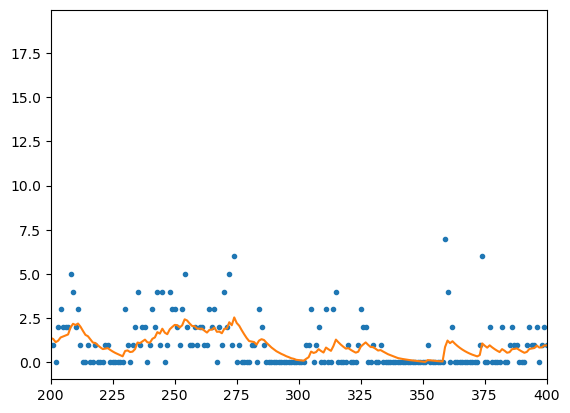

In [21]:
%matplotlib inline
a = np.squeeze(d.neural_data.a)
plt.plot(a[:,0], '.')
b = KernelSmoother(kernel_length=25, tau=8).offline_run_on(a, convinient_return=False)
b = np.squeeze(b[0])
plt.plot(b[:,0])
plt.xlim([200, 400])

In [22]:
d = Leventhal24uDataset(bin_size=.1)
p = Pipeline([
    KernelSmoother(tau=8),
    CenteringTransformer(),
    proSVD(k=6, init_size=50, whiten=False, log_level=0),
    # mmICA()
])
output = p.offline_run_on(d.neural_data, convinient_return=True)


Reading Intan Technologies RHD Data File, Version 1.5

Found 64 amplifier channels.
Found 3 auxiliary input channels.
Found 1 supply voltage channel.
Found 8 board ADC channels.
Found 16 board digital input channels.
Found 16 board digital output channels.
Found 0 temperature sensors channels.

Header file contains no data.  Amplifiers were sampled at 20.00 kS/s.
Done!  Elapsed time: 0.0 seconds


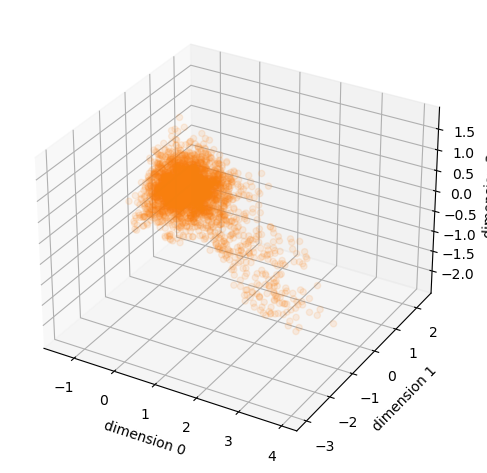

In [23]:
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
axes = (0,1,2)

start = 2000
time_slice = slice(start, start + 3000)

ax.scatter(output[time_slice, axes[0]], output[time_slice, axes[1]], output[time_slice, axes[2]], alpha=.1, color='C1')
ax.set_xlabel(f'dimension {axes[0]}')
ax.set_ylabel(f'dimension {axes[1]}')
ax.set_zlabel(f'dimension {axes[2]}')
plt.tight_layout()
plt.axis('equal');

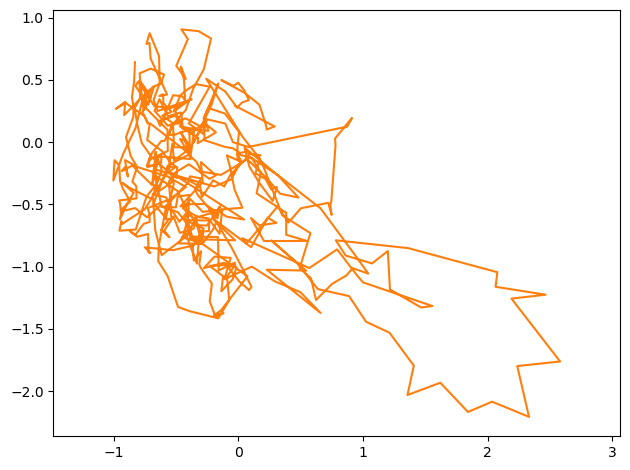

In [24]:
fig, ax = plt.subplots()
# plt.scatter(output[100:, 0], output[100:, 1], alpha=.1)
plt.plot(output[-500:, 0], output[-500:, 1], color='C1')
plt.tight_layout()
plt.axis('equal');

In [ ]:
%matplotlib inline
d = Leventhal24uDataset(bin_size=.1)
p = Pipeline([
    KernelSmoother(tau=8),
    CenteringTransformer(),
    proSVD(k=6, init_size=50, whiten=False, log_level=0),
    KernelSmoother(tau=1),
    mmICA()
])

start = 1238
video_time = 40
tq = tqdm(total=start+video_time)

with AnimationManager(fps=40) as am:
    output = []
    for i, output_row in enumerate(p.streaming_run_on(d.neural_data, return_output_stream=False)):
        if i < 100:
            continue
        output.append(output_row)
        o = np.squeeze(output)

        next_t = d.neural_data.current_sample_time()
        if len(o.shape) == 2 and start < next_t < start + video_time:
            am.axs[0,0].cla()
            am.axs[0,0].autoscale(True)
            
            am.axs[0,0].scatter(o[:,0], o[:,1], alpha=.999**np.arange(o.shape[0])[::-1], color='C0', linewidth=0, s=5)
            am.axs[0,0].plot(o[-10:,0], o[-10:,1], color='C1')
            am.axs[0,0].set_title(f'{i}')
            am.axs[0,0].axis('equal')

            # if np.abs(next_t - (d.trial_data['Time'] + d.trial_data['preTone'])).min() < .5:
            if np.abs(next_t - (d.trial_data['Time'])).min() < .5:
                x = (am.axs[0,0].transAxes + am.axs[0,0].transData.inverted()).transform((.98,.98))
                am.axs[0,0].autoscale(False)
                am.axs[0,0].scatter(*x, color='green', s=100)

            am.grab_frame()
        elif next_t > start + video_time:
            break
        tq.update(np.floor(next_t - tq.n).astype(int))


In [ ]:
%matplotlib inline

d = Leventhal24uDataset(bin_size=.1)

pipelines = [
    Pipeline([
        KernelSmoother(tau=8),
        CenteringTransformer(),
        proSVD(k=6),
        KernelSmoother(tau=8),
        mmICA()
    ]),
    # Pipeline([
    #     KernelSmoother(tau=8),
    #     CenteringTransformer(),
    #     proSVD(k=6, whiten=True),
    #     KernelSmoother(tau=8),
    #     mmICA()
    # ]),
]

start = 1238 # in s
video_time = 80 # in s
tq = tqdm(total=start+video_time)

with AnimationManager(fps=40) as am:
    
    outputs = [[] for p in pipelines]
    for i, output_rows in enumerate(zip(*[p.streaming_run_on(d.neural_data) for p in pipelines])):
        if i < 100:
            continue
        
        for j, row in enumerate(output_rows):
            outputs[j].append(row)
        os = [np.squeeze(o) for o in outputs]

        next_ts = [p.mid_run_sources[0][0].current_sample_time() for p in pipelines]
        assert all(t == next_ts[0] for t in next_ts)
        next_t = next_ts[0]
        o = os[0]
        if len(o.shape) == 2 and start < next_t < start + video_time:
            am.ax[0,0].cla()
            am.ax[0,0].autoscale(True)
            
            for j, o in enumerate(os):
                am.ax[0,0].scatter(o[:,0], o[:,1], alpha=.999**np.arange(o.shape[0])[::-1], color=f'C{j}', linewidth=0, s=5)
                am.ax[0,0].plot(o[-10:,0], o[-10:,1], color=f'C{j}')
            am.ax[0,0].set_title(f'frame={i}, time={next_t:.1f}')
            am.ax[0,0].axis('equal')

            # if np.abs(next_t - (d.trial_data['Time'] + d.trial_data['preTone'])).min() < .5:
            if np.abs(next_t - (d.trial_data['Time'])).min() < .5:
                dot_point = np.array([.98,.98])
                # dot_point = (am.ax[0,0].transAxes + am.ax[0,0].transData.inverted()).transform(dot_point)
                # am.ax[0,0].autoscale(False)
                dot_point = dot_point * 10
                am.ax[0,0].scatter(*dot_point, color='green', s=100)

            am.ax[0,0].set_xlim([-10, 10])
            am.ax[0,0].set_ylim([-10, 10])
            am.grab_frame()
        elif next_t > start + video_time:
            break
        tq.update(np.floor(next_t - tq.n).astype(int))
